# Importing Dependencies

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Reading the Data

In [14]:
# --- Load Data ---
df = pd.read_csv("dataFiles/HINDUNILVR_cleaned.csv", index_col="Date", parse_dates=True)
# df = df.tail(7000)
close_prices = df['Close'].values.reshape(-1, 1)

# Plots over time


<Axes: xlabel='Date', ylabel='Close'>

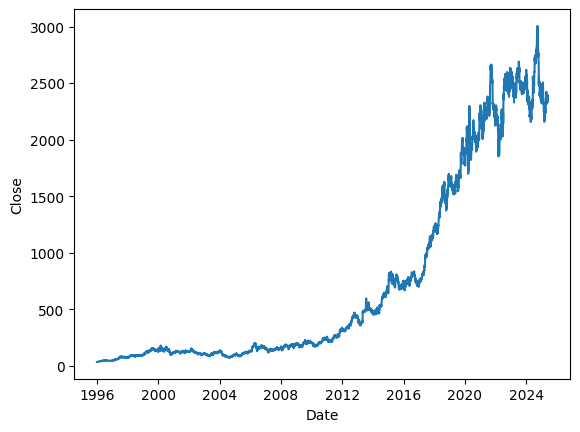

In [15]:
sns.lineplot(data = df, x = "Date", y = "Close")

# RNN

In [18]:

# --- Min-Max Scaling ---
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

# --- Create Windowed Data ---
def create_dataset(data, look_back=5):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 5
X, y = create_dataset(scaled_prices, look_back)

# --- Train-Test Split (80-20) ---
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- RNN Model ---
model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    SimpleRNN(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# --- Predictions ---
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# --- Inverse Transform ---
train_pred_inv = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train)
test_pred_inv = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test)




Epoch 1/20


/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0122
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6247e-04
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6439e-04
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3342e-04
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4813e-04
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8048e-04
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9570e-04
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7837e-04
Epoch 9/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9422e-04
Epoch 10/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3106e-04
Epoch 11/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2092e-04
Epoch 12/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2225e-04
Epoch 13/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1799e-04
Epoch 14/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2193e-04
Epoch 15/20
185/

--- Train ---
RMSE: 12.549930639501808
MAE : 7.4183463326515104
R^2 : 0.9988990253174366

--- Test ---
RMSE: 62.20472077743585
MAE : 47.55694389860158
R^2 : 0.9495524943924365



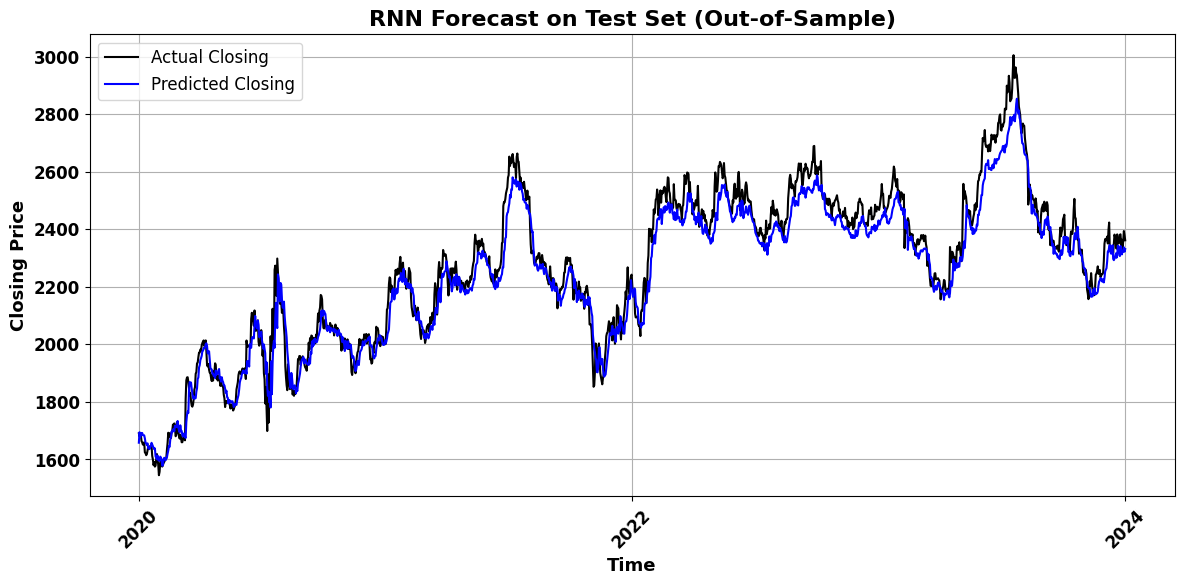

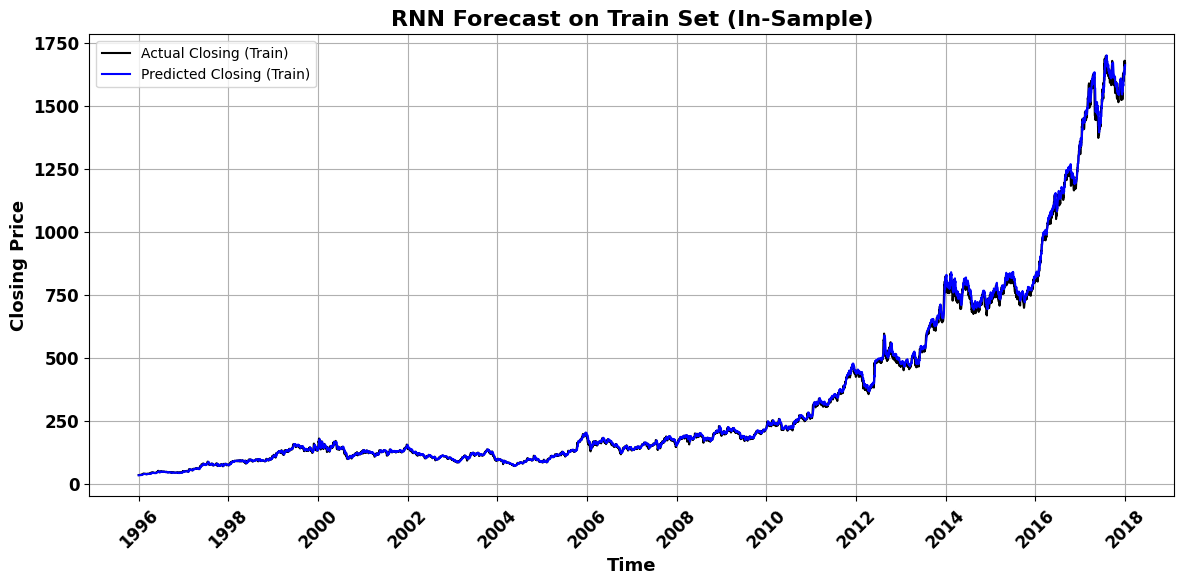

In [19]:
# --- Evaluation ---
def evaluate(true, pred, name="Set"):
    print(f"--- {name} ---")
    print("RMSE:", np.sqrt(mean_squared_error(true, pred)))
    print("MAE :", mean_absolute_error(true, pred))
    print("R^2 :", r2_score(true, pred))
    print()

evaluate(y_train_inv, train_pred_inv, "Train")
evaluate(y_test_inv, test_pred_inv, "Test")

# Create fake "years" for x-axis (adjust length to your data)
years1 = np.arange(1996, 2020, 2)  # 1996 to 2025 in 2-year steps
years2 = np.arange(2020, 2026, 2) 

# Create evenly spaced tick positions for years
tick_positions1 = np.linspace(0, len(y_train_inv)-1, len(years1)).astype(int)
tick_positions2 = np.linspace(0, len(y_test_inv)-1, len(years2)).astype(int)

# --- Plotting ---
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label="Actual Closing", color='black')
plt.plot(test_pred_inv, label="Predicted Closing", color='blue')
plt.title("RNN Forecast on Test Set (Out-of-Sample)",fontsize=16,fontweight='bold')
plt.xlabel("Time",fontsize=13,fontweight='semibold')
plt.ylabel("Closing Price",fontsize=13,fontweight='semibold')
plt.xticks(tick_positions2, years2, fontsize=12, fontweight='bold', rotation=45)
plt.yticks(fontsize=12, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(y_train_inv, label="Actual Closing (Train)", color='black')
plt.plot(train_pred_inv, label="Predicted Closing (Train)", color='blue')
plt.title("RNN Forecast on Train Set (In-Sample)",fontsize=16,fontweight='bold')
plt.xlabel("Time",fontsize=13,fontweight='semibold')
plt.ylabel("Closing Price",fontsize=13,fontweight='semibold')
plt.xticks(tick_positions1, years1, fontsize=12, fontweight='bold', rotation=45)
plt.yticks(fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()